In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import altair as alt
from sublimpy import utils
from sublimpy import variables
from sublimpy import tidy
from metpy.units import units
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.optimize import curve_fit

alt.data_transformers.disable_max_rows()
import datetime as dt

In [2]:
fn = "/Users/elischwat/Development/data/sublimationofsnow/infrared_camera/250917_for_Eli/230517_120045_frames14000_to_66999_avg300.nc"

In [3]:
RESAMPLE_FREQ = '30min'

# Open a 30-min dataset

In [4]:
ds = xr.open_dataset(fn, chunks="auto")  # Lazily opens the NetCDF file with Dask
ds = ds.compute() # it's not that big (right now)

# Define the starting time and timestep
start_time = pd.Timestamp("2023-05-17 12:00:00")
timestep = pd.Timedelta(seconds=10)

In [5]:
# calculate a time coordinate
time_values = start_time + ds['frame'] * timestep
ds = ds.assign_coords(time=("frame", pd.Index(time_values)))

# and create reynolds averages
ds = ds.resample(time=RESAMPLE_FREQ).mean()['irdata'].T[::-1,::,::]

# Define function for plotting throughout the notebook

In [6]:
def plot_frames(src, figsize=(15, 5), vmin=0, vmax=15, cmap='turbo',):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    
    # Create the plots
    for t, ax in zip(src.time, axes.flatten()):
        im = src.sel(time=t).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
        ax.set_aspect('equal')

    # Add a single shared colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position: [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label="Colorbar Label")

    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colorbar
    # plt.show()

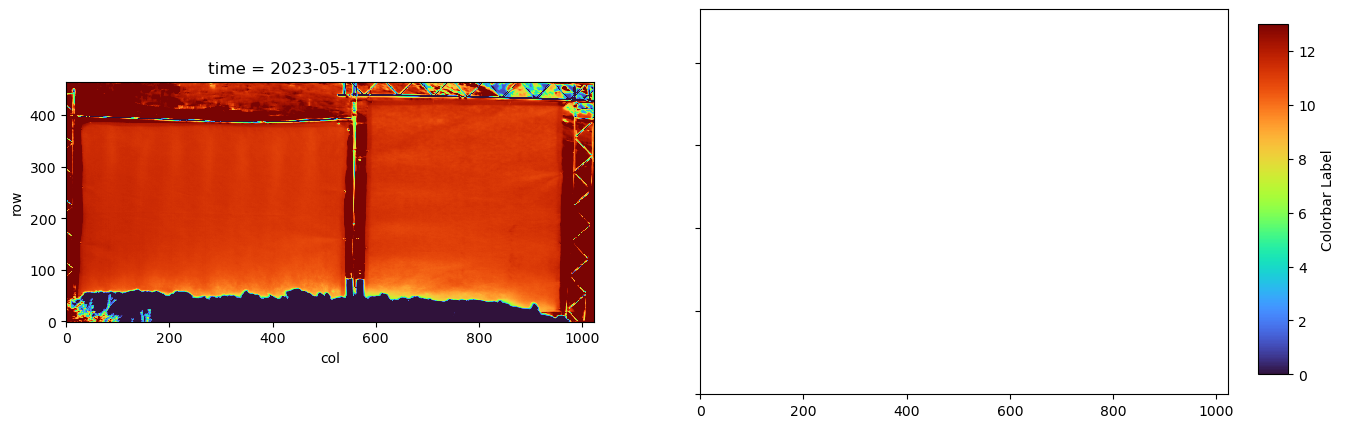

In [7]:
plot_frames(ds, vmax=13)
plt.show()

# Trim the data so we only see good data from the sheet

Remove data at the bottom

In [8]:
ds = ds.sel(row=slice(15,ds.row.values.max()))

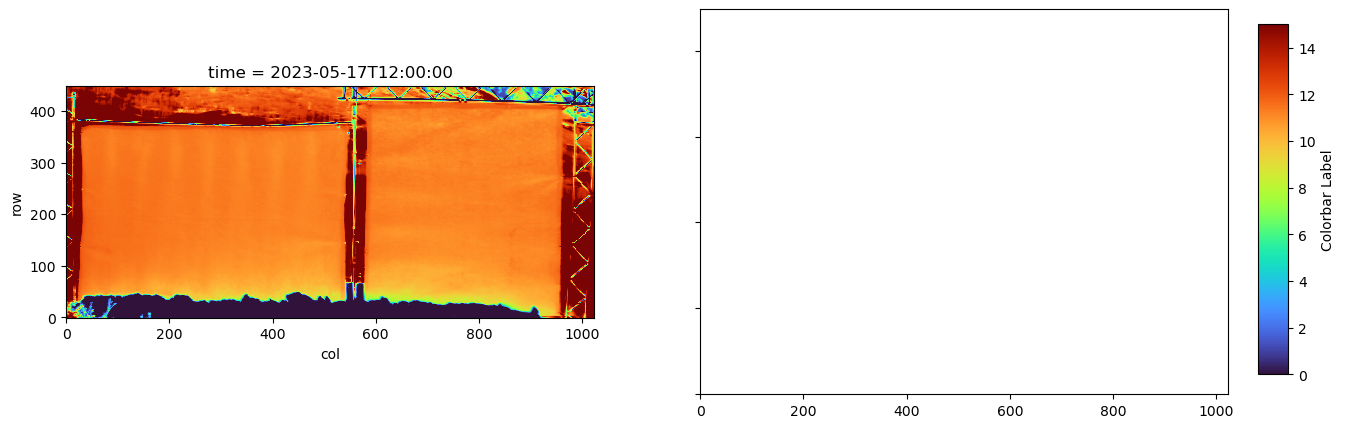

In [9]:
plot_frames(ds)
plt.show()

Grab a subset of the data so col starts at and ends at the left and right boundaries of the two sheets.

In [10]:
ds = ds.sel(col=slice(35,915))

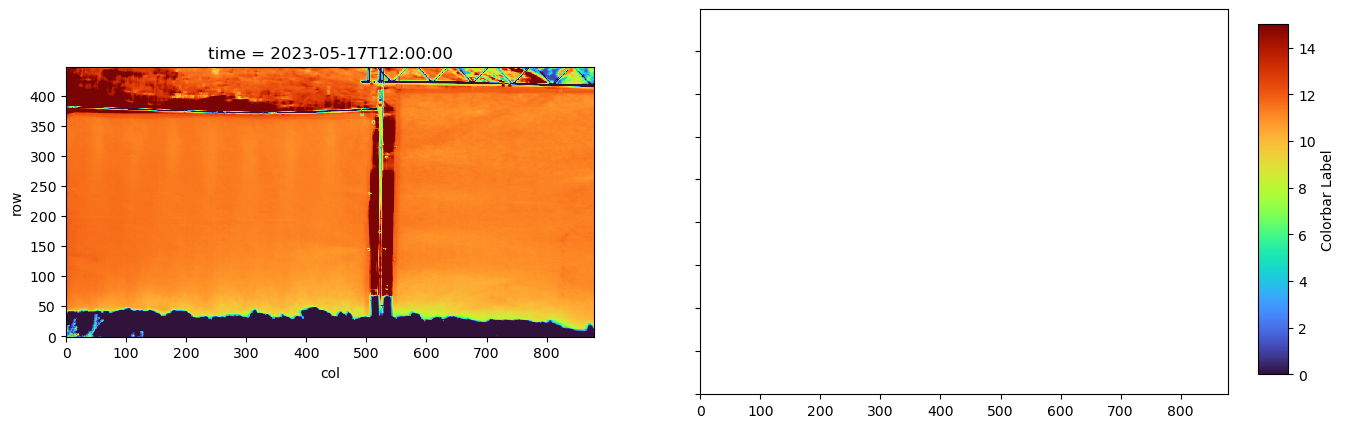

In [11]:
plot_frames(ds)
plt.show()

Now let's cut off the top

In [12]:
ds = ds.sel(
    row = slice(0,370)
)

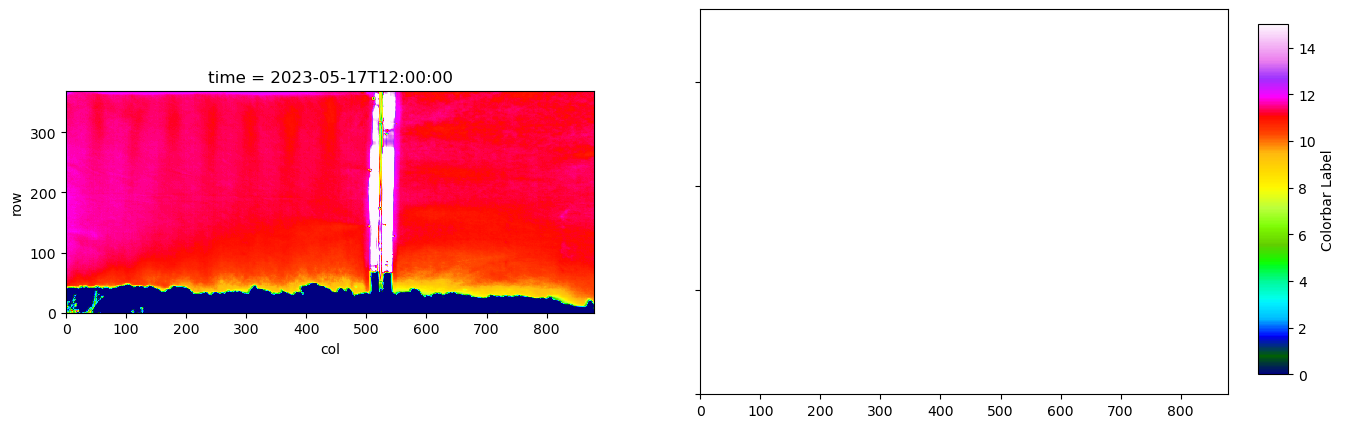

In [13]:
plot_frames(ds, cmap='gist_ncar')
plt.show()

Remove the data in between the two sheets

In [14]:
# ds = ds.where(
#     (ds.col < 495)
#     | (ds.col > 560)
# )

ds = ds.where(
    (ds.col < 490)
    | (ds.col > 565)
)

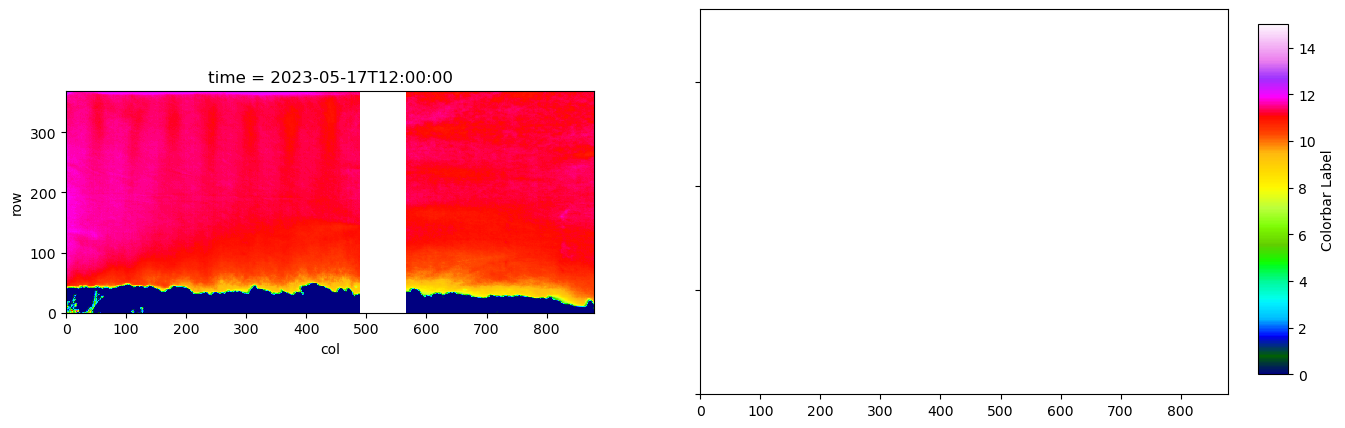

In [15]:
plot_frames(ds, cmap='gist_ncar')
plt.show()

Convert the spatial dimensions to actual distances

Length relations: 
* the fixation of the left horizontal bar at the leftmost vertical bar is at 1.90m above the (bare) surface. 
* The left horizontal bar from vertical post to vertical post is 2.92m long. 
* The right horizontal bar from vertical post to vertical post is 2.06m. The bottom of the right horizontal bar is 2.26m above bare ground at the middle vertical post. Sorry, a lot of numbers...

i.e...
* total width of the col dimension, i.e. from the left edge of left sheet to right edge of right sheet is: 2.06 + 2.92 = **4.98 meters**
* total height of the row dimension, i.e. from where the pole meets the ground to the top support pole, is **1.9 meters**

In [16]:
TOTAL_WIDTH = 4.98
TOTAL_HEIGHT = 1.9

## FOR THE GRIDDED DATA
# create coords x and why, scaling the col and row dimensions using the dimensions of the observations/sheets
ds = ds.assign_coords(
    x = TOTAL_WIDTH * ds.col / len(ds.col),
    z = TOTAL_HEIGHT * ds.row / len(ds.row)
)

In [17]:
ds.to_dataframe()

x         z     irdata
row col time                                              
0   0   2023-05-17 12:00:00  0.000000  0.000000   7.058753
    1   2023-05-17 12:00:00  0.005659  0.000000   6.633329
    2   2023-05-17 12:00:00  0.011318  0.000000   6.127162
    3   2023-05-17 12:00:00  0.016977  0.000000   7.446158
    4   2023-05-17 12:00:00  0.022636  0.000000   6.628866
...                               ...       ...        ...
369 875 2023-05-17 12:00:00  4.951705  1.894865  11.391520
    876 2023-05-17 12:00:00  4.957364  1.894865  11.320463
    877 2023-05-17 12:00:00  4.963023  1.894865  11.311445
    878 2023-05-17 12:00:00  4.968682  1.894865  11.355872
    879 2023-05-17 12:00:00  4.974341  1.894865  11.369397

[325600 rows x 3 columns]

In [18]:
# replace the dims with the physical ones
ds = ds.to_dataframe().reset_index().set_index(['x', 'z', 'time']).to_xarray().irdata.T

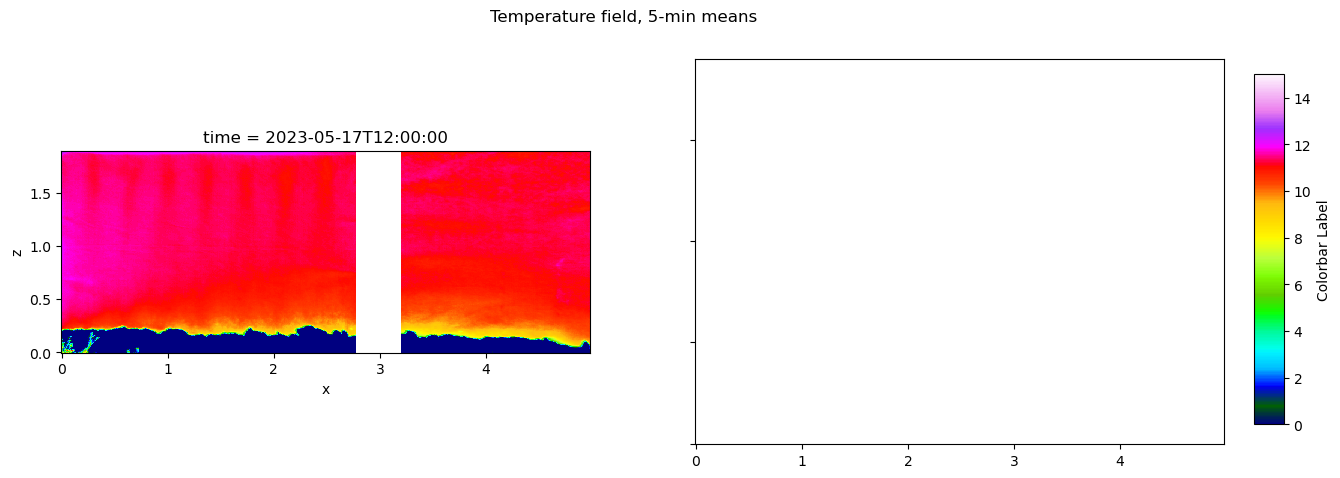

In [19]:
plot_frames(ds, cmap='gist_ncar')
plt.suptitle('Temperature field, 5-min means')
plt.show()


# Find the snow-surface and set values in the snow to NaN

In [20]:
ds_z_reversed = ds.sel(z = slice(None,None,-1))

In [21]:
mask = ds_z_reversed < 0

In [22]:
first_true_indices = mask.argmax(dim='z')
z_values_at_first_true = mask['z'].isel(z=first_true_indices)

In [23]:
sample_filt = ds_z_reversed.where(ds_z_reversed.z > z_values_at_first_true)

In [24]:
ds = sample_filt.sel(z = slice(None,None,-1))

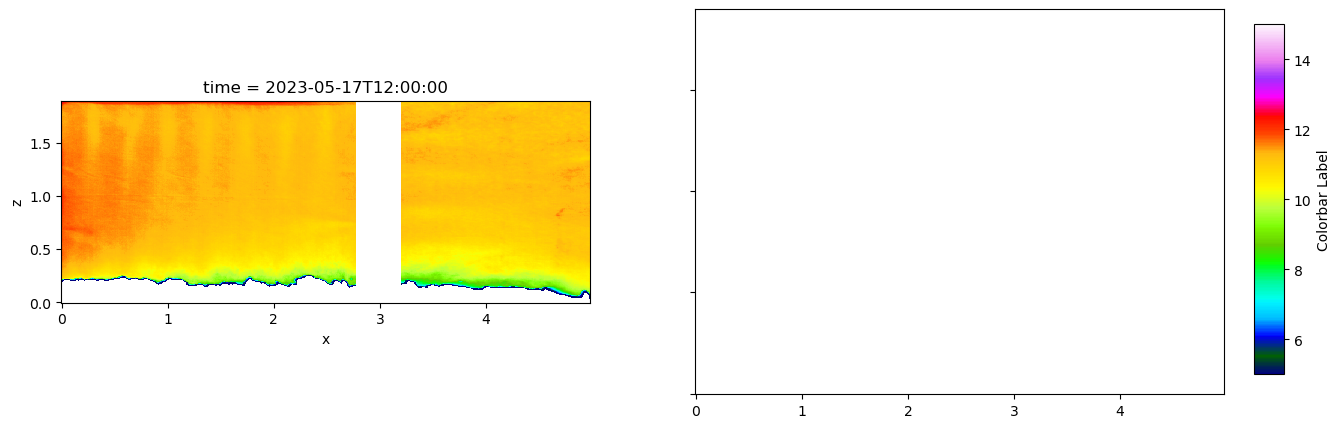

In [25]:
plot_frames(ds, cmap='gist_ncar', vmin=5, vmax=15)

# Error handling - systematic waves

## Examine the horizontal waves

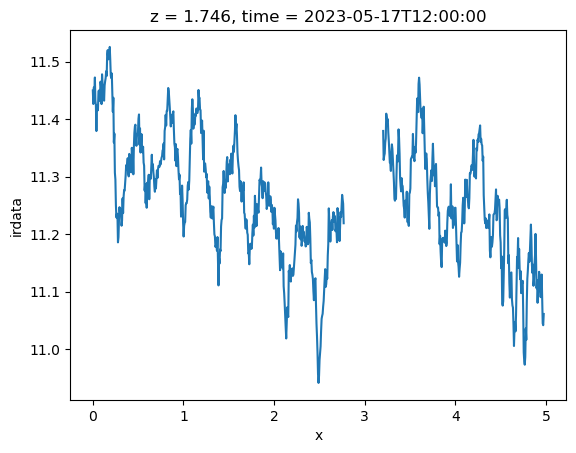

In [26]:
for t in ds.time:
    ds.sel(time=t, z=ds.z[340]).plot()
    plt.show()

In [27]:
src_withnans = ds.sel(time=ds.time[4], z=ds.z[340])
src_filled = src_withnans.interpolate_na(dim='x', method='polynomial', order=3)
src_filled.plot()

IndexError: index 4 is out of bounds for axis 0 with size 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the FFT along the 'x' dimension
fft_result = np.fft.fft(src_filled, axis=src_filled.get_axis_num('x'))

# Compute the frequencies corresponding to the FFT
dx = (src_filled['x'][1] - src_filled['x'][0]).values  # Spacing along the 'x' dimension
freqs = np.fft.fftfreq(src_filled['x'].size, d=dx)

# Plot the FFT magnitude
plt.figure(figsize=(10, 6))
plt.plot(
    freqs,
    np.abs(fft_result),
)
plt.title("FFT of the DataArray")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

NameError: name 'src_filled' is not defined

In [ ]:
import numpy as np
import xarray as xr

# Perform FFT along the 'x' dimension
fft_result = np.fft.fft(src_filled, axis=src_filled.get_axis_num('x'))

# Compute the frequencies corresponding to the FFT
dx = (src_filled['x'][1] - src_filled['x'][0]).values  # Spacing along the 'x' dimension
freqs = np.fft.fftfreq(src_filled['x'].size, d=dx)

# Create a mask to filter out frequencies in the range [2, 4]
filter_mask = (np.abs(freqs) < 0.5) | (np.abs(freqs) > 5)

# Apply the mask to the FFT result
filtered_fft = fft_result * filter_mask

# Perform the inverse FFT to get the filtered signal
filtered_signal = np.fft.ifft(filtered_fft, axis=src_filled.get_axis_num('x')).real

# Create a new DataArray with the filtered signal
filtered_src_filled_ifft = xr.DataArray(
    filtered_signal,
    dims=src_filled.dims,
    coords=src_filled.coords,
    attrs=src_filled.attrs
)

NameError: name 'src_filled' is not defined

In [ ]:
from scipy.signal import butter, filtfilt

# Define a bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Design bandpass filter
    return filtfilt(b, a, data)  # Apply filter

# Parameters for the bandpass filter
lowcut = 0.5  # Lower cutoff frequency
highcut = 5  # Upper cutoff frequency
fs = 1 / (src_filled['x'][1] - src_filled['x'][0]).values  # Sampling frequency

# Apply the bandpass filter to the data
filtered_signal = bandpass_filter(src_filled.values, lowcut, highcut, fs)

# Create a new DataArray for the filtered signal
filtered_src_filled_bandpass = src_filled.copy(data=filtered_signal)
filtered_src_filled_bandpass = src_filled - filtered_src_filled_bandpass

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
# Plot the original and filtered signals
src_filled.plot(label='original', ax=axes[0])
filtered_src_filled_bandpass.plot(label='filtered', ax=axes[0])
src_filled.plot(label='original', ax=axes[1])
filtered_src_filled_ifft.plot(label='ifft', ax=axes[1])
_ = [ax.legend() for ax in axes]
plt.show()

In [ ]:
filtered_src_withnans_bandpass = filtered_src_filled_bandpass.where(~np.isnan(src_withnans))

In [ ]:
src_withnans.plot(label='original')
filtered_src_withnans_bandpass.plot(label='filtered')
plt.legend()
plt.show()

## Using the bandpass filter method illustrated above, apply the filter to every row of data

In [ ]:
ds_subset = ds.sel(x = slice(0,2.7)).copy(deep=True)
ds_subset_corrected = ds.sel(x = slice(0,2.7)).copy(deep=True)

In [ ]:
# PERFORM FREQUENCY FILTERING
from scipy.signal import butter, filtfilt   

for t in range(0, len(ds_subset.time)):
    for row in ds_subset.z:
        if row.item() > 0.75:
            # FILL NANS
            src_withnans = ds_subset.sel(time=ds_subset[t].time,z=row.item())
            src_filled = src_withnans.interpolate_na(dim='x', method='polynomial', order=3)

            

            # Define a bandpass filter function
            def bandpass_filter(data, lowcut, highcut, fs, order=4):
                # from scipy.signal import butter, filtfilt   
                nyquist = 0.5 * fs  # Nyquist frequency
                low = lowcut / nyquist
                high = highcut / nyquist
                b, a = butter(order, [low, high], btype='band')  # Design bandpass filter
                return filtfilt(b, a, data)  # Apply filter

            # Parameters for the bandpass filter
            lowcut = 0.5  # Lower cutoff frequency
            highcut = 5  # Upper cutoff frequency
            fs = 1 / (src_filled['x'][1] - src_filled['x'][0]).values  # Sampling frequency

            # Apply the bandpass filter to the data
            filtered_signal = bandpass_filter(src_filled.values, lowcut, highcut, fs)

            # Create a new DataArray for the filtered signal
            filtered_src_filled_bandpass = src_filled.copy(data=filtered_signal)
            filtered_src_filled_bandpass = src_filled - filtered_src_filled_bandpass
            filtered_src_withnans_bandpass = filtered_src_filled_bandpass.where(~np.isnan(src_withnans))
            ds_subset_corrected.loc[dict(time=ds_subset[t].time,z=row.item())] = filtered_src_withnans_bandpass

In [ ]:
for t in range(0, len(ds_subset.time)):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    ds_subset.isel(time=t).plot(cmap='gist_ncar', vmin=5, vmax=15, ax=axes[0])
    ds_subset_corrected.isel(time=t).plot(cmap='gist_ncar', vmin=5, vmax=15, ax=axes[1])
    axes[0].set_title('Original')
    axes[1].set_title('Band filtered')
    plt.show()

# Set the internal boundary layer depth

 - above that height, we will not calculate advected energy

We manually select this based on the "blending height" we observe above

In [ ]:
MAX_INTEGRATION_DEPTH = 0.75

# Adjust the snow surface to make it flat

In [ ]:
ds_adj = ds.copy(deep=True)

In [ ]:
for t in range(ds.sizes['time']):
    print(t)
        
    # Example: ds_1frame is the xarray.DataArray with dimensions ('z', 'x')

    # Step 1: Find the first non-NaN index along the 'z' dimension for each column
    first_non_nan_idx = ds_adj.isel(time=t).notnull().argmax(dim='z')

    # # Step 3: Shift each column downward
    for x in ds_adj.isel(time=t)['x']:
        shift_idx = first_non_nan_idx.sel(x=x).item()  # Get the shift index for this column
        shifted = ds_adj.isel(time=t).sel(x=x).roll(z=-shift_idx)
        ds_adj.isel(time=t).loc[dict(x=x)] = shifted

0


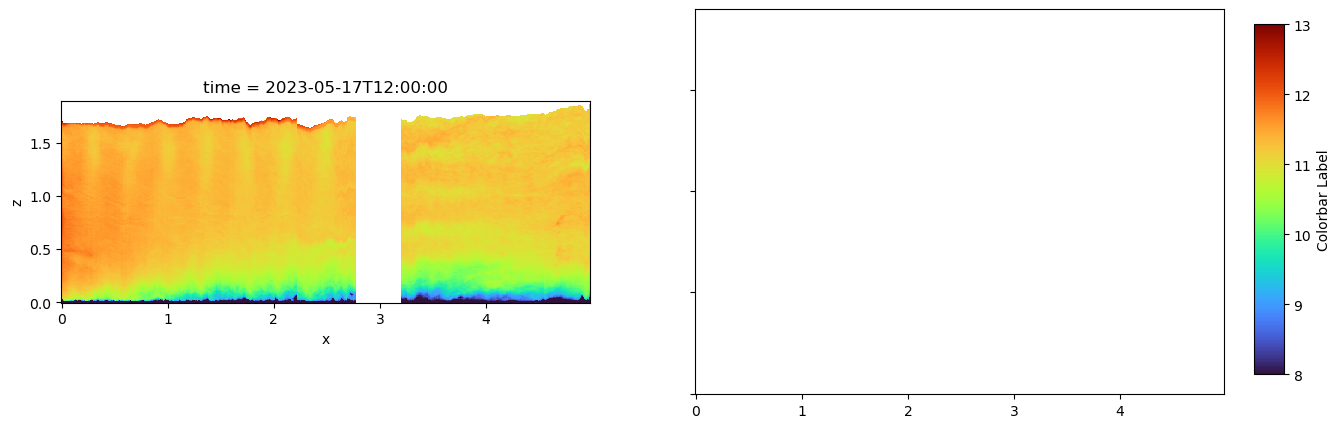

In [ ]:
plot_frames(ds_adj, vmin=8, vmax=13)

# Calculate sensible heat flux into snow for each of 6 frames

$$ < H_O > = H_u + Q_a $$

where $H_u$ is the heat flux upwind of the snow-patch, $Q_a$ is the advected energy. 

$$ Q_a = \frac{\Delta S}{X_s} = \frac{\rho c_p}{X_s} \int^B_0 U(z)  \Big(T(z)_u - T(z)_s \Big) dz $$

$\Delta$ S is the *difference in horizontal transport of heat* between the upwind and downwind edges of the snow-patch, and $X$ is the length of the snow-patch.

We will assume the following for $U(z)$, both to solve for $z_0$, but also to model a wind profile across the 2D domain.

$$ U(z) = \frac{u_*}{k} \text{ln} \frac{z}{z_0} \qquad | \qquad z_0 = z \text{exp} \Big[ - \frac{k}{u_*} U(z) \Big]$$

Split the dataset into 6 datasets. We need to treat each 5-minute frame separately, because the z coordinate changes for each 5-minute frame, because the calculated $z_0$ for each frame is different

In [ ]:
ds_adj_frames_list = [
    ds_adj.isel(time=i) for i in range(len(ds_adj.time))
]

Open sos data, for upwind boundary conditions and calculate $z_0$

In [ ]:
file =  "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/isfs_sos_qc_geo_tiltcor_5min_v2_20230517.nc"
sos_ds = xr.open_dataset(file)
sos_ds = utils.modify_xarray_timezone(sos_ds, 'UTC', 'US/Mountain').sel(
    time = slice('20230517 12:02:30', '20230517 12:27:30')
)
sos_ds = sos_ds.assign_coords(
    time = pd.to_datetime(sos_ds.time.values) - dt.timedelta(minutes=2, seconds=30)
)

In [ ]:
sos_ds = sos_ds.resample(time=RESAMPLE_FREQ).mean()

Solve for z0

 - we will use mean values over 30 minutes

In [ ]:
z = 2
u_star = np.sqrt(np.sqrt(sos_ds['u_w__2m_c']**2 + sos_ds['v_w__2m_c']**2))
U = sos_ds['spd_2m_c']
k = 0.41
z_0 = z * np.exp(
    - (k / u_star) * U
)

In [ ]:
print(z)
print(u_star.values)
print(U.values)
print(k)
print(z_0.values)

2
[0.25337148]
[3.3591554]
0.41
[0.00871628]


In [ ]:
c_p = 1000.5 * units('joules/(K*kg)')
rho_a = 1 * units("kg/m^3")

In [ ]:
# WE SHOULD MAKE SURE TO USE TOWER C here b/c tower UW may still be impacted by the snow drift
H_u = (sos_ds['w_tc__2m_c'].values * units(
    "kelvin * m/s"
) * c_p * rho_a).to(units("W/m^2")).magnitude
# Make it negative to conform with Essery et al's convention
H_u = - H_u
H_u

array([-122.8669], dtype=float32)

In [ ]:
def get_U(z, z_0_val, u_star_val):
    return (u_star_val/k)*np.log(z / z_0_val)

Create 2D arrays of U(z) values

In [ ]:
# adjust the coordinate system so that the bottom is at ∆Z above the roughness length
# this is necessary b/c U goes to 0 at the roughness length
for i, ds_1frame in enumerate(ds_adj_frames_list):
    Delta_Z = ds_1frame.z.diff(dim='z').values[0]
    ds_adj_frames_list[i] = ds_1frame.assign_coords(z=ds_1frame.z + Delta_Z + z_0[i])

In [ ]:
U_ds_list = []

for i, ds_1frame in enumerate(ds_adj_frames_list):    
    # Create a 2D field of nans, that will be filled with U values
    U_ds = xr.full_like(ds_1frame, fill_value=np.nan)
    z_values = ds_1frame['z']
    U_ds[:] = get_U(z_values, z_0[i], u_star[i])
    U_ds_list.append(U_ds)

Overwrite the first 5cm of data using with the mean profile from the range of measurements. 

In [ ]:
for i, ds_1frame in enumerate(ds_adj_frames_list):
    # Compute the 1D array (mean over the x slice)
    upwind_profile = ds_1frame.sel(x = slice(0, 0.05)).mean(dim='x')
    # Assign this 1D array to each column in the dataset
    ds_adj_frames_list[i].loc[dict(x=slice(0.0, 0.05))] = upwind_profile

(0.0, 0.3)

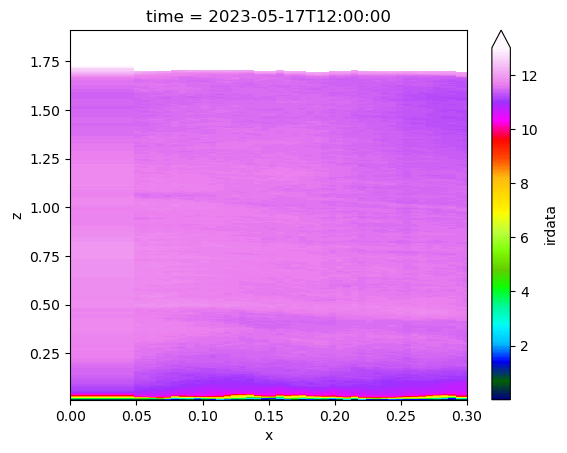

In [ ]:
ds_adj_frames_list[i].plot(cmap='gist_ncar', vmax=13)
plt.xlim(0,0.3)

Calculate $Q_a$ for a different distances into the snow patch that we extracted temp profile data for.

$$ Q_a = \frac{\Delta S}{X_s} = \frac{\rho c_p}{X_s} \int^B_0 U(z)  \Big(T(z)_u - T(z)_s \Big) dz $$

In [ ]:
Tdiff_ds_list = []
for i, ds_1frame in enumerate(ds_adj_frames_list):
    Tdiff_1frame = ds_1frame - ds_1frame.isel(x=0)
    Tdiff_ds_list.append(Tdiff_1frame)

In [ ]:
Qa_ds_list = []
H0_ds_list = []
for i in range(len(Tdiff_ds_list)):
    Tdiff_ds_1frame = Tdiff_ds_list[i]
    U_ds_1frame = U_ds_list[i]

    U_ds_times_Tdiff = Tdiff_ds_1frame * U_ds_1frame
    Qa_ds = - (
        rho_a.magnitude * c_p.magnitude /
        U_ds_times_Tdiff.x
    ) * U_ds_times_Tdiff.sel(z = slice(0, MAX_INTEGRATION_DEPTH)).integrate(coord = 'z')
    H0_ds = H_u[i] + Qa_ds
    Qa_ds_list.append(Qa_ds)
    H0_ds_list.append(H0_ds)


# Qa_ds = - (
#     rho_a.magnitude * c_p.magnitude /
#     U_ds_times_Tdiff_1frame_ds.x
# ) * U_ds_times_Tdiff_1frame_ds.sel(z = slice(0, MAX_INTEGRATION_DEPTH)).integrate(coord = 'z')
# H0_ds = H_u.magnitude + Qa_ds

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


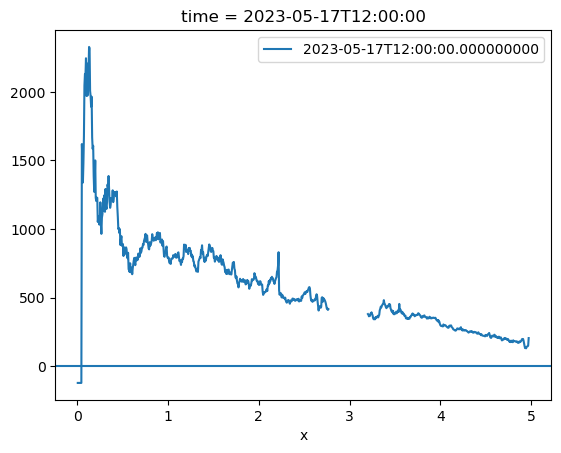

In [ ]:
H0_ds_list[0].plot(label = H0_ds_list[0].time.values)
# H0_ds_list[1].plot(label = H0_ds_list[1].time.values)
# H0_ds_list[2].plot(label = H0_ds_list[2].time.values)
# H0_ds_list[3].plot(label = H0_ds_list[3].time.values)
# H0_ds_list[4].plot(label = H0_ds_list[4].time.values)
# H0_ds_list[5].plot(label = H0_ds_list[5].time.values)
plt.legend()
plt.axhline(0)

# Model - Following Essery et al., 2002, Equation 22

## Outline

In [ ]:
print(H_u)

[-122.8669]


In [ ]:
print(u_star)

<xarray.DataArray (time: 1)> Size: 4B
array([0.25337148], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-05-17T12:00:00


In [ ]:
print(z_0)

<xarray.DataArray (time: 1)> Size: 4B
array([0.00871628], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2023-05-17T12:00:00


In [ ]:
print(rho_a)

1.0 kilogram / meter ** 3


In [ ]:
print(c_p)

1000.5 joule / kelvin / kilogram


In [ ]:
print(k)

0.41


We need to define the following:

* $ T_b$ = known temperature at the top IBL

* $ T_0$ = known temperature of the snow surface

* $ z_b$ = boundary layer height, a function of x

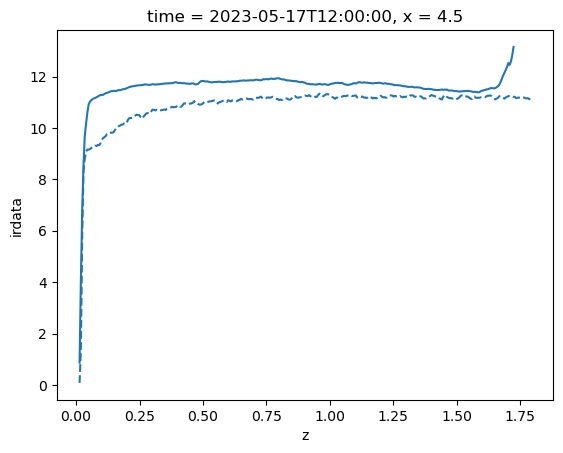

In [ ]:
ds_adj_frames_list[0].sel(x=0).plot(color='tab:blue')
# ds_adj_frames_list[1].sel(x=0).plot(color='tab:orange')
# ds_adj_frames_list[2].sel(x=0).plot(color='tab:red')
# ds_adj_frames_list[3].sel(x=0).plot(color='tab:green')
# ds_adj_frames_list[4].sel(x=0).plot(color='tab:purple')
# ds_adj_frames_list[5].sel(x=0).plot(color='tab:grey')

ds_adj_frames_list[0].interp(x=4.5).plot(linestyle='--', color='tab:blue')
# ds_adj_frames_list[1].interp(x=4.5).plot(linestyle='--', color='tab:orange')
# ds_adj_frames_list[2].interp(x=4.5).plot(linestyle='--', color='tab:red')
# ds_adj_frames_list[3].interp(x=4.5).plot(linestyle='--', color='tab:green')
# ds_adj_frames_list[4].interp(x=4.5).plot(linestyle='--', color='tab:purple')
# ds_adj_frames_list[5].interp(x=4.5).plot(linestyle='--', color='tab:grey')

In [ ]:
T_b = [
    ds_adj_1frame.sel(z = slice(1.0,1.5)).sel(x=0).mean().item() * units('degC') 
    for ds_adj_1frame in ds_adj_frames_list 
]
T_0 = 0 * units('degC')
print(T_b)
print(T_0)

[<Quantity(11.63748927852407, 'degree_Celsius')>]
0 degree_Celsius


From Essery et al., 2002,
$$ H_0(x) = H_u - Q_a $$ 

$$ 
Q_a = \frac{1}{E(z_b)} \Bigg[ 
        H_u \text{ln} \Big( \frac{z_b + z_0}{z_0} \Big)
        + \rho c_p k u_* (T_b - T_0)
    \Bigg]
$$

Note that $Q_a$ is not directly a function of $x$, but is implicitly, do to it's being a function of $z_b$.

In [ ]:
# Where does this a come from again? Look at Essery.
a = 4.74*units("dimensionless")

def E(z, z_b, z_0):
    argument = lambda z: (1 + (a*z)/z_b)*np.exp( - (a*z)/(z_b))*(1 / (z + z_0))
    integral, _ = scipy.integrate.quad(argument, 0, z)  # Integrate argument from 0 to z
    return integral 

def Q_a(z_b, z_0, H_u, u_star, T_b, T_0):
    return - (1 / E(z_b.magnitude, z_b.magnitude, z_0.magnitude))*(
        H_u * np.log((z_b+z_0)/z_0) + rho_a*c_p*k*u_star*(T_b - T_0)
    )

Note that Q_a does not actually rely on x directly above, but it does rely on x through z_b, which is a function of x. The z_b value we chose was for x= 2.5, per the plot above. But we can do better - let's... 

**Fit z_b(x) to our data**

We will search for the lowest point (in each column) where T_diff < $\epsilon$.

Let's start with \epsilon = 0.05

In [ ]:
EPSILON = 0.2

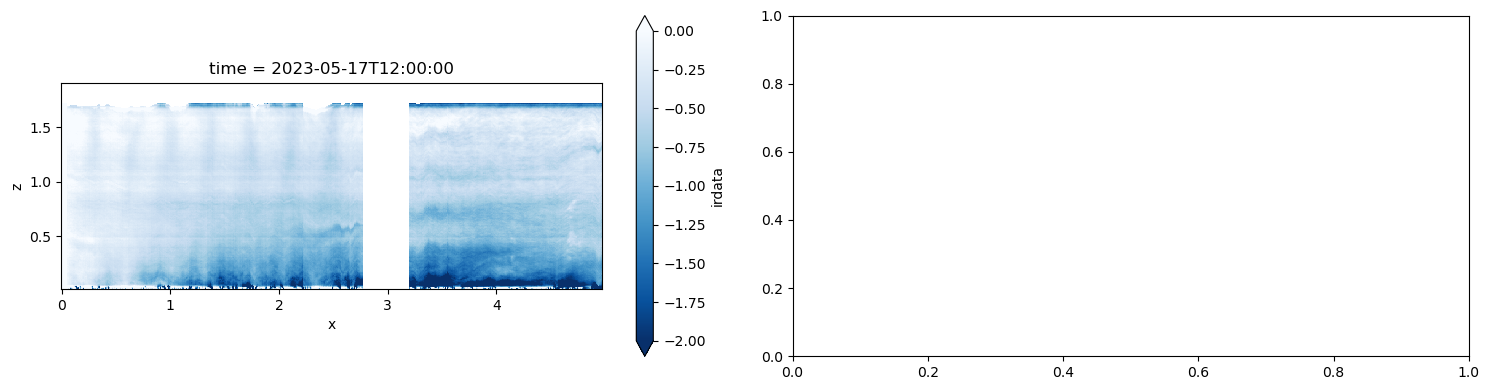

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
for i in range(len(Tdiff_ds_list)):
    ds = Tdiff_ds_list[i]
    ax = axes.flatten()[i]
    ds.plot(ax=ax, vmin=-2, vmax=0, cmap='Blues_r')
    ax.set_aspect('equal')
plt.tight_layout()

Filter out some rogue data at the top and bottom of the frames (?)

In [ ]:
for i in range(len(Tdiff_ds_list)):
    Tdiff_ds_list[i] = Tdiff_ds_list[i].sel(z = slice(0.03, 1.65))

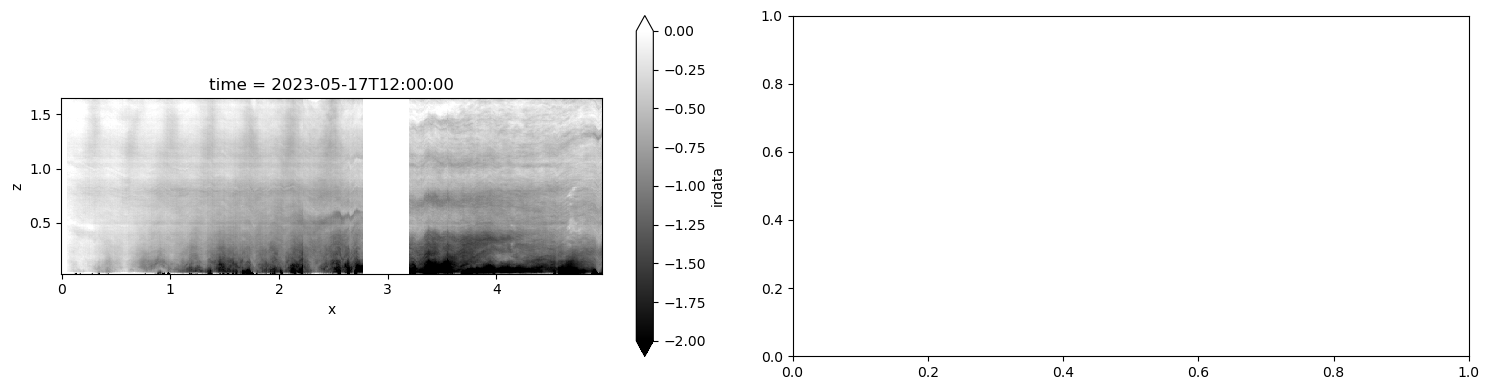

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
for i in range(len(Tdiff_ds_list)):
    ds = Tdiff_ds_list[i]
    ax = axes.flatten()[i]
    ds.plot(ax=ax, vmin=-2, vmax=0, cmap='grey')
    ax.set_aspect('equal')
plt.tight_layout()

Create masks

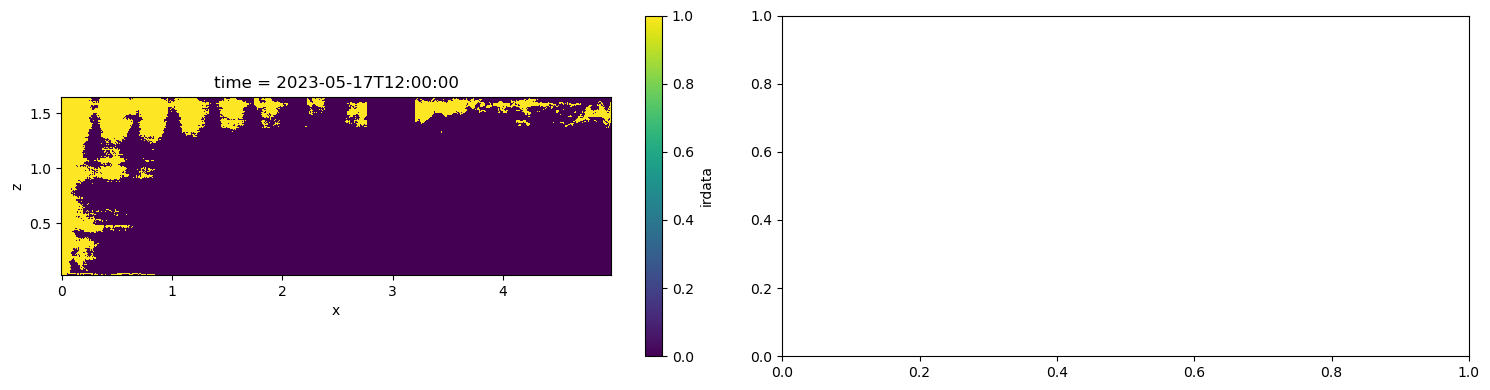

In [ ]:
mask_ds_list = []

fig, axes = plt.subplots(1,2, figsize=(15,4))
for i in range(len(Tdiff_ds_list)):
    ds = Tdiff_ds_list[i]
    ax = axes.flatten()[i]
    mask = (np.abs(ds) < EPSILON) & (~ds.isnull())
    mask_ds_list.append(mask)
    mask.plot(ax=ax)
    ax.set_aspect('equal')
plt.tight_layout()

Gather points for the estimated internal boundary layer height

In [ ]:
ibl_height_points_df_ls = []
for mask, Tdiff_ds in zip(mask_ds_list, Tdiff_ds_list):
    # Find the first maximum value, searching from the bottom up (i.e. find the lowest yellow point in each column, in the plots of the masks above)
    first_indices = mask.argmax(dim='z')
    first_indices = first_indices.where(mask.any(dim='z'), drop=False)
    z_b_values_measured = pd.DataFrame(
        pd.Series(first_indices).apply(lambda i: Tdiff_1frame.z.values[int(i)] if ~np.isnan(i) else np.nan).rename('z')
    )
    z_b_values_measured['x'] = z_b_values_measured.index.to_series().apply(lambda i: Tdiff_1frame.x.values[int(i)] if ~np.isnan(i) else np.nan)
    
    # filter out the bottom points
    z_b_values_measured = z_b_values_measured[z_b_values_measured > 0.1]
    z_b_values_measured = z_b_values_measured.dropna()

    # Filter errnous points in the lower right part of our screen
    z_b_values_measured = z_b_values_measured.assign(
        drop = (
            (z_b_values_measured.x > 3)
            &
            (z_b_values_measured.z < 0.8)
        )
        
    )
    z_b_values_measured = z_b_values_measured[~ z_b_values_measured['drop']]

    ibl_height_points_df_ls.append(z_b_values_measured)

In [ ]:
ibl_height_points_df_mins_ls = []
for z_b_values_measured in ibl_height_points_df_ls:
    # bin and choose minimums to get rid of noise
    # bin_edges = np.arange(z_b_values_measured['x'].min(), z_b_values_measured['x'].max() + 0.25, 0.25)
    bin_edges = np.arange(z_b_values_measured['x'].min(), z_b_values_measured['x'].max() + 0.5, 0.5)
    z_b_values_measured['x_binned'] = pd.cut(z_b_values_measured['x'], bins=bin_edges, include_lowest=True).apply(
        lambda interval: float(0.5*(interval.left + interval.right))
    )
    z_b_values_measured_binned_mins = pd.DataFrame(z_b_values_measured.groupby('x_binned').z.min())
    z_b_values_measured_binned_mins.index.name = 'x'
    z_b_values_measured_binned_mins = z_b_values_measured_binned_mins.reset_index()
    z_b_values_measured_binned_mins.x = z_b_values_measured_binned_mins.x.astype(float)
    ibl_height_points_df_mins_ls.append(z_b_values_measured_binned_mins)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25714/3608736469.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z_b_values_measured_binned_mins = pd.DataFrame(z_b_values_measured.groupby('x_binned').z.min())


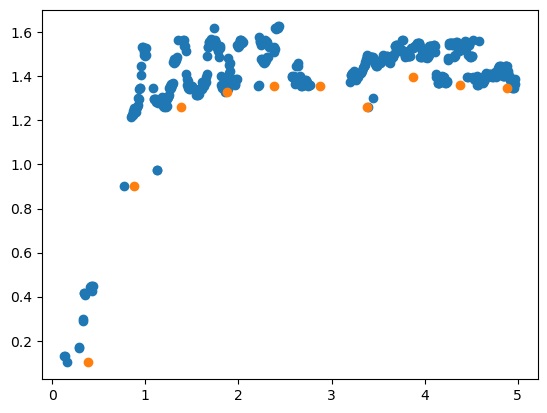

In [ ]:
for z_b_values_measured,z_b_values_measured_binned_mins in zip(ibl_height_points_df_ls, ibl_height_points_df_mins_ls):
    plt.scatter(z_b_values_measured.x, z_b_values_measured.z)
    plt.scatter(z_b_values_measured_binned_mins.x, z_b_values_measured_binned_mins.z)
    plt.show()

Fitted parameters: c=0.8744609849754914, b=0.35249633032716726


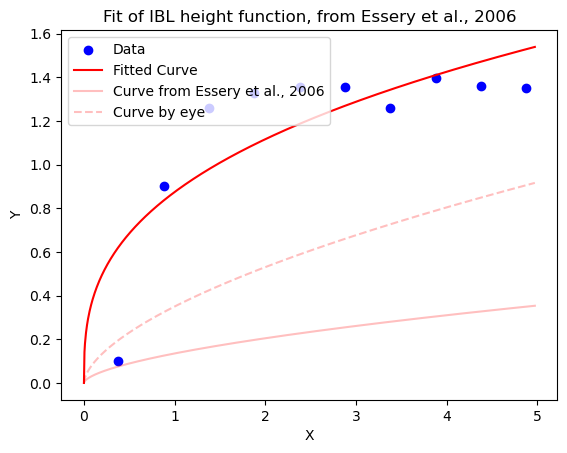

In [ ]:
X_fit_ls = []
Y_fit_ls = []
Y_fit_from_literature_ls = []
Y_fit_fit_by_eye_ls = []
c_fit_ls = []
b_fit_ls = []

for z_b_values_measured_binned_mins in ibl_height_points_df_mins_ls:
    def ibl_height(X, c, b):
        return c*X**b
    
    X = z_b_values_measured_binned_mins.x
    Y = z_b_values_measured_binned_mins.z

    # Fit the ibl_height function to the data
    popt, pcov = curve_fit(ibl_height, X, Y, p0=[0.135, 0.6], bounds=([0, 0], [1, 1]))  # Initial guesses for c and b

    # Extract fitted parameters
    c_fit, b_fit = popt
    print(f"Fitted parameters: c={c_fit}, b={b_fit}")

    # Generate fitted curve
    X_fit = Tdiff_1frame.x.values
    Y_fit = ibl_height(X_fit, c_fit, b_fit)

    # Generate curve from literature
    Y_fit_from_literature = ibl_height(X_fit, 0.135, 0.6) # from: grangerBoundarylayerGrowthSnow2006

    # Generate my own, by eye, curve
    Y_fit_fit_by_eye = ibl_height(X_fit, 0.35, 0.6) # from: grangerBoundarylayerGrowthSnow2006

    X_fit_ls.append(X_fit)
    Y_fit_ls.append(Y_fit)
    Y_fit_from_literature_ls.append(Y_fit_from_literature)
    Y_fit_fit_by_eye_ls.append(Y_fit_fit_by_eye)
    c_fit_ls.append(c_fit)
    b_fit_ls.append(b_fit)

    # Plot the original data and the fitted curve
    plt.scatter(X, Y, label="Data", color="blue")
    plt.plot(X_fit, Y_fit, label="Fitted Curve", color="red")
    plt.plot(X_fit, Y_fit_from_literature, label="Curve from Essery et al., 2006", color="red", alpha=0.25)
    plt.plot(X_fit, Y_fit_fit_by_eye, label="Curve by eye", color="red", alpha=0.25, linestyle='--')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title("Fit of IBL height function, from Essery et al., 2006")
    plt.show()

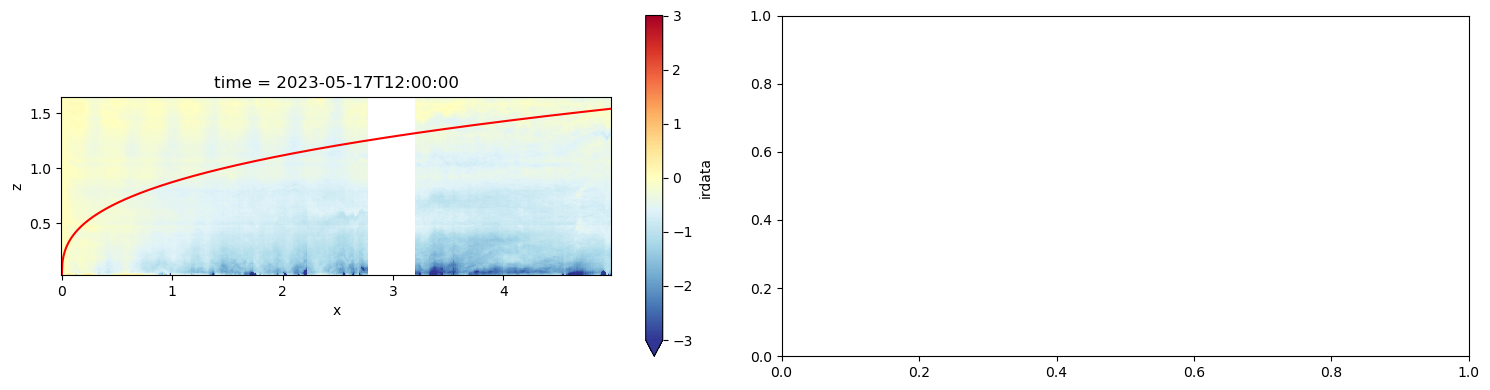

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,4))
for i in range(len(Tdiff_ds_list)):
    ds = Tdiff_ds_list[i]
    ax = axes.flatten()[i]
    ds.plot(ax=ax, vmin=-3, vmax=3, cmap='RdYlBu_r')
    ax.set_aspect('equal')

    X_fit = X_fit_ls[i]
    Y_fit = Y_fit_ls[i]
    Y_fit_from_literature = Y_fit_from_literature_ls[i]
    Y_fit_fit_by_eye = Y_fit_fit_by_eye_ls[i]
    c_fit = c_fit_ls[i]
    b_fit = b_fit_ls[i]

    ax.plot(X_fit, Y_fit, label="Fitted Curve", color="red")
    # ax.plot(X_fit, Y_fit_from_literature, label="Curve from Essery et al., 2006", color="red", alpha=0.25)
    # ax.plot(X_fit, Y_fit_fit_by_eye, label="Curve by eye", color="red", alpha=0.25, linestyle='--')
    # ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
f"c = [{c_fit_ls}]", f"b = [{b_fit_ls}]",

('c = [[0.8744609849754914]]', 'b = [[0.35249633032716726]]')

Now calculate Q_a and H_0, same as above, but integrating up until the z_b values calculated with the models shown above

In [ ]:
Qa_ds_z_b_fit_list = []
Qa_ds_z_b_literature_list = []
Qa_ds_z_b_eye_list = []
H0_ds_z_b_fit_list = []
H0_ds_z_b_literature_list = []
H0_ds_z_b_eye_list = []
for i in range(len(Tdiff_ds_list)):
    Tdiff = Tdiff_ds_list[i]
    U = U_ds_list[i]
    X_fit = X_fit_ls[i]
    Y_fit = Y_fit_ls[i]
    Y_fit_from_literature = Y_fit_from_literature_ls[i]
    Y_fit_fit_by_eye = Y_fit_fit_by_eye_ls[i]

    z_b_fit = pd.DataFrame({'x': X_fit, 'z_b': Y_fit}).set_index(['x']).to_xarray()
    z_b_literature = pd.DataFrame({'x': X_fit, 'z_b': Y_fit_from_literature}).set_index(['x']).to_xarray()
    z_b_eye = pd.DataFrame({'x': X_fit, 'z_b': Y_fit_fit_by_eye}).set_index(['x']).to_xarray()

    U_times_Tdiff = U * Tdiff

    Qa_ds_z_b_fit = - (
        rho_a.magnitude * c_p.magnitude /
        Tdiff.x
    ) * U_times_Tdiff.where(U_times_Tdiff.z < z_b_fit.z_b, other=0).integrate(coord = 'z')
    H0_ds_z_b_fit = H_u[i] + Qa_ds_z_b_fit
    Qa_ds_z_b_fit_list.append(Qa_ds_z_b_fit)
    H0_ds_z_b_fit_list.append(H0_ds_z_b_fit)

    Qa_ds_z_b_literature = - (
        rho_a.magnitude * c_p.magnitude /
        Tdiff.x
    ) * U_times_Tdiff.where(U_times_Tdiff.z < z_b_literature.z_b, other=0).integrate(coord = 'z')
    H0_ds_z_b_literature = H_u[i] + Qa_ds_z_b_literature
    Qa_ds_z_b_literature_list.append(Qa_ds_z_b_literature)
    H0_ds_z_b_literature_list.append(H0_ds_z_b_literature)

    Qa_ds_z_b_eye = - (
        rho_a.magnitude * c_p.magnitude /
        Tdiff.x
    ) * U_times_Tdiff.where(U_times_Tdiff.z < z_b_eye.z_b, other=0).integrate(coord = 'z')
    H0_ds_z_b_eye = H_u[i] + Qa_ds_z_b_eye
    Qa_ds_z_b_eye_list.append(Qa_ds_z_b_eye)
    H0_ds_z_b_eye_list.append(H0_ds_z_b_eye)

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25714/4120506606.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


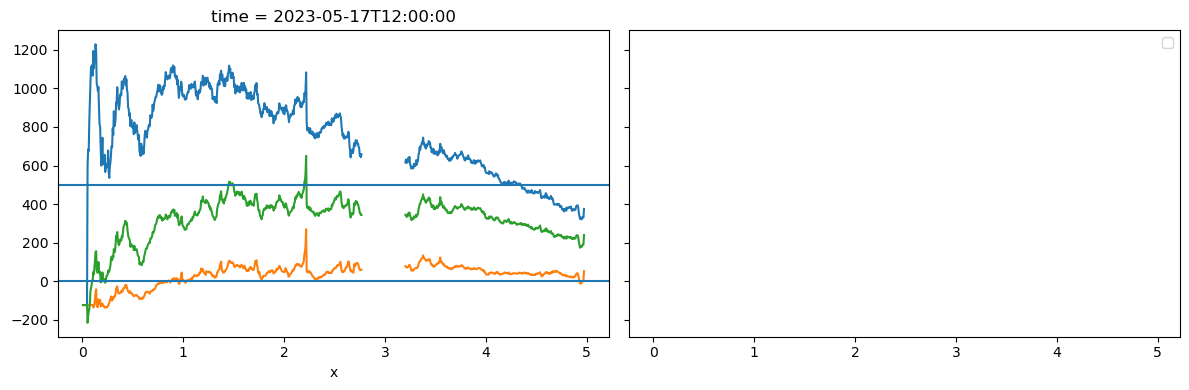

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
for i in range(len(Tdiff_ds_list)):
    ax = axes.flatten()[i]

    H0_ds_z_b_fit = H0_ds_z_b_fit_list[i]
    H0_ds_z_b_literature = H0_ds_z_b_literature_list[i]
    H0_ds_z_b_eye = H0_ds_z_b_eye_list[i]

    H0_ds_z_b_fit.plot(ax=ax, label='z_b fit to data')
    H0_ds_z_b_literature.plot(ax=ax, label='z_b from Essery et al. (2006)')
    H0_ds_z_b_eye.plot(ax=ax, label='z_b fitted by eye')
    ax.axhline(500)
    ax.axhline(0)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# def fitted_ibl_height(X, c, b):
def fitted_ibl_height(X, c=0.135, b=0.6):
    return c*X**b

In [ ]:
# Q_a(z_b, z_0, H_u, u_star, T_b, T_0)
model_results_ls = []
for i in range(len(c_fit_ls)):
    c = c_fit_ls[i]
    b = b_fit_ls[i]
    model_results = pd.DataFrame({
        'x': np.linspace(0.1,10,100),
        'Q_a': [(
            (Q_a(
                fitted_ibl_height(X, c, b) * units("m"),
                z_0.values[i] * units("m"),
                H_u[i] * units("W / m^2"),
                u_star.values[i] * units("m / s"),
                T_b[0].to(units("kelvin")),
                T_0.to(units("kelvin")),
            )).round()
        ).magnitude.item() for X in np.linspace(0.1,10,100)],
    })
    model_results['H_0'] = H_u[i] - model_results['Q_a']
    model_results['<H_0>'] = model_results['H_0'].expanding().mean()
    model_results_ls.append(model_results)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_25714/2557357688.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


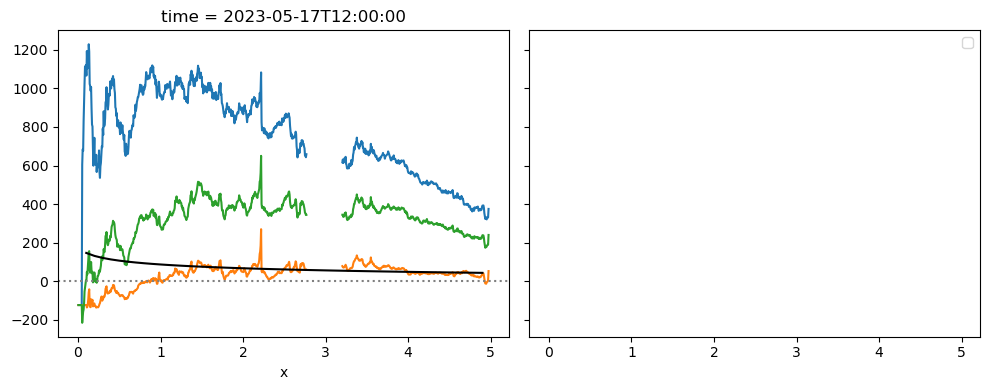

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
for i in range(len(Tdiff_ds_list)):
    ax = axes.flatten()[i]

    H0_ds_z_b_fit = H0_ds_z_b_fit_list[i]
    H0_ds_z_b_literature = H0_ds_z_b_literature_list[i]
    H0_ds_z_b_eye = H0_ds_z_b_eye_list[i]

    H0_ds_z_b_fit.plot(ax=ax, label='z_b fit to data')
    H0_ds_z_b_literature.plot(ax=ax, label='z_b from Essery et al. (2006)')
    H0_ds_z_b_eye.plot(ax=ax, label='z_b fitted by eye')
    model_results_ls[i].query(
        f"x <= {H0_ds_z_b_fit.x.values.max()}"
    ).set_index('x')['<H_0>'].plot(ax=ax, label = 'Modeled', color='black')
    ax.axhline(0, color='grey', linestyle=':')
    plt.legend()

plt.tight_layout()
plt.show()

# Scale up to distribution of patch lengths

In [209]:
patch_lengths = pd.read_csv('../uav_data/patch_lengths.csv')

In [210]:
def calculate_H_0_for_patch_length(L_p, c, b, z_0, H_u, u_star, T_b, T_0):
    return (
        H_u - Q_a(
            fitted_ibl_height(L_p, c, b) * units("m"),
            z_0 * units("m"),
            H_u * units("W / m^2"),
            u_star * units("m / s"),
            T_b.to(units("kelvin")),
            T_0.to(units("kelvin")),
        ).magnitude.item()
    ).round()

for i in range(len(c_fit_ls)):
    patch_lengths[f'H_0_{i}'] = patch_lengths.patch_length.apply(
        lambda L_p:
        calculate_H_0_for_patch_length(
            L_p, 
            c_fit_ls[i], 
            b_fit_ls[i], 
            z_0.values[i], 
            H_u[i], 
            u_star.values[i], 
            T_b[i], 
            T_0
        )
    )

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/pint/facets/plain/quantity.py:984: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(self._magnitude, other_magnitude)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24733/3318786345.py:6: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral, _ = scipy.integrate.quad(argument, 0, z)  # Integrate argument from 0 to z


In [212]:
for ds in U_ds_list:
    U_ds.mean()

In [213]:
base = alt.Chart(patch_lengths).transform_fold([
    '<H_0>_0', '<H_0>_1', '<H_0>_2', '<H_0>_3', '<H_0>_4', '<H_0>_5'
])

base.mark_bar(opacity=0.5).encode(
    alt.X('value:Q').bin(step=20).axis(values = [-200,-150,-100,-50,0,50,100,150,200,250,300,350,400]),
    alt.Y('count()', stack=False),
    alt.Color('key:N'),
)

alt.Chart(...)

In [214]:
base.mark_text().encode(
    # alt.X('value:Q').bin(step=20).axis(values = [-200,-150,-100,-50,0,50,100,150,200,250,300,350,400]),
    # alt.Y('count()', stack=False),
    alt.X('mean(value):Q', axis=alt.Axis(values=[-200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350, 400])),

    alt.Color('key:N'),
    alt.Text('mean(value):Q')
)

alt.Chart(...)

In [215]:
alt.Chart(patch_lengths).transform_fold(
    [
        '<H_0>_0', '<H_0>_1', '<H_0>_2', '<H_0>_3', '<H_0>_4', '<H_0>_5'
    ]
).transform_density(
    density='value',
    groupby=['key'],
    as_=['value', 'density']
).mark_line().encode(
    alt.X('value:Q', axis=alt.Axis(values=[-200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350, 400])),
    alt.Y('density:Q'),
    alt.Color('key:N')
) + alt.Chart(patch_lengths).transform_fold(
    [
        '<H_0>_0', '<H_0>_1', '<H_0>_2', '<H_0>_3', '<H_0>_4', '<H_0>_5'
    ]
).mark_rule().encode(
    alt.X('mean(value):Q', axis=alt.Axis(values=[-200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350, 400])),
    alt.Color('key:N')
) + alt.Chart(patch_lengths.round(2)).transform_fold(
    [
        '<H_0>_0', '<H_0>_1', '<H_0>_2', '<H_0>_3', '<H_0>_4', '<H_0>_5'
    ]
).mark_text().encode(
    alt.X('mean(value):Q', axis=alt.Axis(values=[-200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300, 350, 400])),
    alt.Color('key:N'),
    alt.Text('mean(value):Q')
)

alt.LayerChart(...)